In [0]:
!wget https://datashare.is.ed.ac.uk/bitstream/handle/10283/3192/CINIC-10.tar.gz

--2020-05-03 18:20:50--  https://datashare.is.ed.ac.uk/bitstream/handle/10283/3192/CINIC-10.tar.gz
Resolving datashare.is.ed.ac.uk (datashare.is.ed.ac.uk)... 129.215.41.53
Connecting to datashare.is.ed.ac.uk (datashare.is.ed.ac.uk)|129.215.41.53|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 687544992 (656M) [application/gzip]
Saving to: ‘CINIC-10.tar.gz’

CINIC-10.tar.gz     100%[===================>] 655.69M   407KB/s    in 27m 33s 

2020-05-03 18:48:24 (406 KB/s) - ‘CINIC-10.tar.gz’ saved [687544992/687544992]



In [0]:
%%bash
mkdir 'CINIC-10'
tar -xvf '/CINIC-10.tar.gz' -C '/CINIC-10'

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



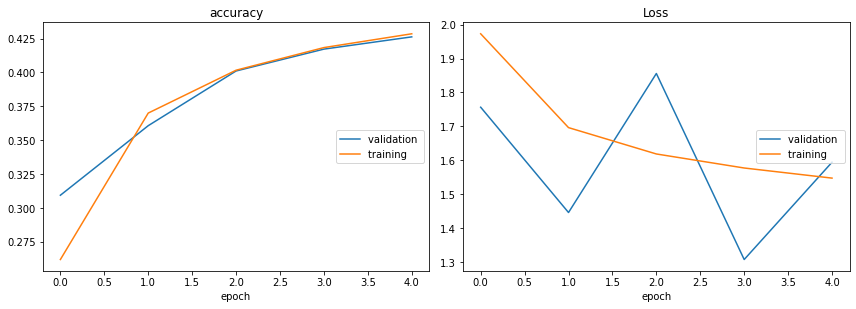

accuracy
	validation       	 (min:    0.309, max:    0.426, cur:    0.426)
	training         	 (min:    0.262, max:    0.428, cur:    0.428)
Loss
	validation       	 (min:    1.308, max:    1.856, cur:    1.594)
	training         	 (min:    1.548, max:    1.973, cur:    1.548)
dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


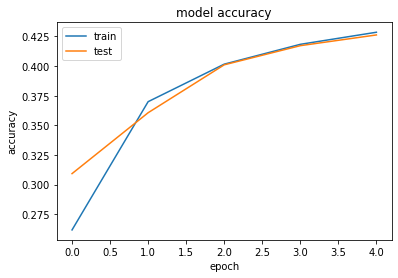

Scores:  [1.7293695211410522, 0.4262222349643707]
Accuracy: 42.62%
Erro modelo CNN cifar10 simples: 57.38%


In [0]:
import numpy as np
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
import matplotlib.pyplot as plt
from PIL.Image import fromarray
from livelossplot import PlotLossesKeras
import matplotlib.pyplot as plt
import  tensorflow as tf
import keras.backend.tensorflow_backend as tfback

def _get_available_gpus():  

    if tfback._LOCAL_DEVICES is None:  
        devices = tf.config.list_logical_devices()  
        tfback._LOCAL_DEVICES = [x.name for x in devices]  
    return [x for x in tfback._LOCAL_DEVICES if 'device:gpu' in x.lower()]

tfback._get_available_gpus = _get_available_gpus

# fixar random seed para se puder reproduzir os resultados
seed = 9
np.random.seed(seed)

#util para visualizar a topologia da rede num ficheiro em pdf ou png
def print_model(model,fich):
    from keras.utils import plot_model
    plot_model(model, to_file=fich, show_shapes=True, show_layer_names=True)

def print_history_accuracy(history):
    print(history.history.keys())
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

def print_history_loss(history):
    print(history.history.keys())
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

# Etapa 1 - preparar o dataset
'''
fazer o download do CIFAR10 dataset com 60,000 fotos a cores de dimensão 32x32,
divididas em 10 classes (e.g. aviões, automoveis, passaros, gatos,...).
dataset: http://www.cs.toronto.edu/~kriz/cifar.html
O dataset está dividido em 50,000 imagens para treino e 10,000 para teste do modelo
treinado.
Neste dataset muito bons resultados são com acc >90%, conseguindo os humanos ~94%,
state of the arte está em 96%
'''
import os
import pickle
from keras.utils.data_utils import get_file

# Etapa 1 - preparar o dataset
'''
Utilitário para fazer o parse dos dados do CIFAR.
- fpath: path do ficheiro a fazer parse.
- label_key: key do label data no dicionário a retornar
# Retorna um tuplo `(data, labels)`.
'''
def load_batch(fpath, label_key='labels'):
    f = open(fpath, 'rb')
    d = pickle.load(f, encoding='bytes')
    d_decoded = {}
     # decode utf8
    for k, v in d.items():
        d_decoded[k.decode('utf8')] = v
    d = d_decoded
    f.close()
    data = d['data']
    labels = d[label_key]
    data = data.reshape(data.shape[0], 3, 32, 32)
    return data, labels

# Etapa 1 - preparar o dataset
def load_cfar10_dataset():
    '''Loads CIFAR10 dataset, Retorna um tuplo de matrizes Numpy: `(x_train, y_train),
    (x_test, y_test)`. '''
    dirname = 'cifar-10-batches-py'
    origin = 'http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
    path = get_file(dirname, origin=origin, untar=True)
    num_train_samples = 50000
    x_train = np.zeros((num_train_samples, 3, 32, 32), dtype='uint8')
    y_train = np.zeros((num_train_samples,), dtype='uint8')
    for i in range(1, 6):
        fpath = os.path.join(path, 'data_batch_' + str(i))
        data, labels = load_batch(fpath)
        x_train[(i - 1) * 10000: i * 10000, :, :, :] = data
        y_train[(i - 1) * 10000: i * 10000] = labels
    fpath = os.path.join(path, 'test_batch')
    x_test, y_test = load_batch(fpath)
    y_train = np.reshape(y_train, (len(y_train), 1))
    y_test = np.reshape(y_test, (len(y_test), 1))
    if K.image_data_format() == 'channels_last':
        x_train = x_train.transpose(0, 2, 3, 1)
        x_test = x_test.transpose(0, 2, 3, 1)
    return (x_train, y_train), (x_test, y_test)

def visualize_cifar10():
    (X_train, y_train), (X_test, y_test) = cifar10.load_data()
    #(X_train, y_train), (X_test, y_test) = load_cfar10_dataset()
    print(y_train)
    for i in range(0, 9):# cria uma grelha com 3x3 imagens
        plt.subplot(330 + 1 + i)
        plt.imshow(fromarray(X_train[i]))
        plt.show()

# Etapa 2 - Definir a topologia da rede (arquitectura do modelo) e compilar
def create_compile_model_cnn_cifar10_simples(num_classes,epochs):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(32, 32, 3), padding='same', activation='relu',
    kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.2))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_constraint=maxnorm(3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    # Compile model
    lrate = 0.1
    decay = lrate/epochs
    sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

# Etapa 2 - Definir a topologia da rede (arquitectura do modelo) e compilar
def create_compile_model_cnn_cifar10_plus(num_classes,epochs):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
    model.add(Dropout(0.2))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Dropout(0.2))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(1024, activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))
    # Compile model
    lrate = 0.1
    decay = lrate/epochs
    sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

from tensorflow.keras.preprocessing.image import ImageDataGenerator

PATH = 'CINIC-10'
def load_cinic10():
    train_datagen = ImageDataGenerator(rescale=1./255)
    val_datagen = ImageDataGenerator(rescale=1./255)
    training_set = train_datagen.flow_from_directory(PATH+'/train',
                                                     target_size=(32, 32),
                                                     batch_size=64,
                                                     class_mode='categorical')  #tb podia ser class_mode='categorical'
    val_set = val_datagen.flow_from_directory(PATH+'/valid',
                                                target_size=(32, 32),
                                                batch_size=64,
                                                class_mode='categorical')
    return training_set, val_set

def cinic10_utilizando_cnn_simples():
    training_set, val_set = load_cinic10()
    num_classes = 10
    epochs = 5 #25
    model = create_compile_model_cnn_cifar10_simples(num_classes,epochs)
    print(model.summary())
    print_model(model,"cinic10T5_plus.png")
    # treino do modelo: epochs=5, batch size = 64
    plotlosses = PlotLossesKeras()
    history=model.fit_generator(training_set, validation_data=val_set, epochs=epochs, verbose=2, callbacks=[plotlosses])
    print_history_accuracy(history)
    #print_history_loss(history)
    # Avaliação final com os casos de teste
    scores = model.evaluate_generator(val_set, verbose=0)
    print('Scores: ', scores)
    print("Accuracy: %.2f%%" % (scores[1]*100))
    print("Erro modelo CNN cifar10 simples: %.2f%%" % (100-scores[1]*100))

def cinic10_utilizando_cnn_plus():
    training_set, val_set = load_cinic10()
    num_classes = 10
    epochs = 5 #25
    model = create_compile_model_cnn_cifar10_plus(num_classes,epochs)
    print(model.summary())
    print_model(model,"cinic10T5_plus.png")
    # treino do modelo: epochs=5, batch size = 64
    plotlosses = PlotLossesKeras()
    history=model.fit_generator(training_set, validation_data=val_set, epochs=epochs, verbose=2, callbacks=[plotlosses])
    print_history_accuracy(history)
    #print_history_loss(history)
    # Avaliação final com os casos de teste
    scores = model.evaluate_generator(val_set, verbose=0)
    print('Scores: ', scores)
    print("Accuracy: %.2f%%" % (scores[1]*100))
    print("Erro modelo CNN cifar10 simples: %.2f%%" % (100-scores[1]*100))

if __name__ == '__main__':
    #visualize_mnist()
    cinic10_utilizando_cnn_plus()